<h1 style="text-align: center;">Stats Perform Takehome</h1>

#### A workthrough of passing data from one season of association football

In [1]:
# All my imports live here
%matplotlib notebook
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import statsmodels.api as stm
from tqdm.auto import tqdm
from matplotlib import cm
import mplcursors
from scipy.stats import pearsonr

In [2]:
# Get an overview of my diretory
os.listdir()

['.ipynb_checkpoints',
 'Data Scientists Task-Short.pdf',
 'data_science_event_definitions.docx',
 'Images',
 'Passing_Patterns.pdf',
 'pass_data.csv',
 'README.txt',
 'requirements.txt',
 'StatsPerform Takehome.ipynb',
 '__MACOSX']

In [3]:
#load data into a pandas dataframe

df = pd.read_csv("pass_data.csv")
df.head()

,team_id,game_id,player_id,home_id,away_id,home_score,away_score,half,minute,second,...,endx,endy,hd_pass,cross,corner,throw,gk,gk_throw,fk_taken,chipped
0,0,0,0,0,1,1,1,1,0,1,...,30.765,32.844,0,0,0,0,0,0,0,0
1,0,0,1,0,1,1,1,1,0,2,...,26.880,21.828,0,0,0,0,0,0,0,0
2,0,0,2,0,1,1,1,1,0,6,...,49.455,19.040,0,0,0,0,0,0,0,0
3,0,0,3,0,1,1,1,1,0,11,...,76.440,13.124,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,1,1,0,14,...,102.375,27.404,0,0,0,0,0,0,0,0


In [4]:
df.info(verbose = "True")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358789 entries, 0 to 358788
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   team_id     358789 non-null  int64  
 1   game_id     358789 non-null  int64  
 2   player_id   358789 non-null  int64  
 3   home_id     358789 non-null  int64  
 4   away_id     358789 non-null  int64  
 5   home_score  358789 non-null  int64  
 6   away_score  358789 non-null  int64  
 7   half        358789 non-null  int64  
 8   minute      358789 non-null  int64  
 9   second      358789 non-null  int64  
 10  outcome     358789 non-null  int64  
 11  x           358787 non-null  float64
 12  y           358785 non-null  float64
 13  endx        358789 non-null  float64
 14  endy        358789 non-null  float64
 15  hd_pass     358789 non-null  int64  
 16  cross       358789 non-null  int64  
 17  corner      358789 non-null  int64  
 18  throw       358789 non-null  int64  
 19  gk

In [5]:
for c in df.columns:
    print(f"{c} ranges from {min(df[c])} to {max(df[c])} and contains {df[c].isna().sum()} Nan values")

team_id ranges from 0 to 19 and contains 0 Nan values
game_id ranges from 0 to 379 and contains 0 Nan values
player_id ranges from 0 to 715 and contains 0 Nan values
home_id ranges from 0 to 19 and contains 0 Nan values
away_id ranges from 0 to 19 and contains 0 Nan values
home_score ranges from 0 to 5 and contains 0 Nan values
away_score ranges from 0 to 4 and contains 0 Nan values
half ranges from 1 to 2 and contains 0 Nan values
minute ranges from 0 to 117 and contains 0 Nan values
second ranges from 0 to 59 and contains 0 Nan values
outcome ranges from 0 to 1 and contains 0 Nan values
x ranges from 0.315 to 104.895 and contains 2 Nan values
y ranges from -1.36 to 69.36 and contains 4 Nan values
endx ranges from -2.1 to 107.1 and contains 0 Nan values
endy ranges from -1.36 to 69.36 and contains 0 Nan values
hd_pass ranges from 0 to 1 and contains 0 Nan values
cross ranges from 0 to 1 and contains 0 Nan values
corner ranges from 0 to 1 and contains 0 Nan values
throw ranges from 0 t

In [6]:
class Pitch(object):
    
    def __init__(self):
        pitch_length = 105
        pitch_width = 68

        # Create a new figure and axis
        fig, ax = plt.subplots()

        # Set the size of the plot
        fig.set_size_inches(7, 5)

        # Set the axis limits and aspect ratio
        ax.set_xlim([0, pitch_length])
        ax.set_ylim([0, pitch_width])
        ax.set_aspect("equal")

        # Add the sidelines and endlines
        ax.plot([0, pitch_length], [0, 0], color="black")
        ax.plot([0, pitch_length], [pitch_width, pitch_width], color="black")
        ax.plot([0, 0], [0, pitch_width], color="black")
        ax.plot([pitch_length, pitch_length], [0, pitch_width], color="black")

        # Add the halfway line
        ax.plot([pitch_length/2, pitch_length/2], [0, pitch_width], color="black")

        # Add the penalty boxes
        penalty_box_width = 40.3
        penalty_box_length = 16.5
        ax.plot([0, penalty_box_length], [(pitch_width-penalty_box_width)/2, (pitch_width-penalty_box_width)/2], color="black")
        ax.plot([0, penalty_box_length], [pitch_width-(pitch_width-penalty_box_width)/2, pitch_width-(pitch_width-penalty_box_width)/2], color="black")
        ax.plot([penalty_box_length, penalty_box_length], [(pitch_width-penalty_box_width)/2, pitch_width-(pitch_width-penalty_box_width)/2], color="black")
        ax.plot([pitch_length, pitch_length-penalty_box_length], [(pitch_width-penalty_box_width)/2, (pitch_width-penalty_box_width)/2], color="black")
        ax.plot([pitch_length, pitch_length-penalty_box_length], [pitch_width-(pitch_width-penalty_box_width)/2, pitch_width-(pitch_width-penalty_box_width)/2], color="black")
        ax.plot([pitch_length-penalty_box_length, pitch_length-penalty_box_length], [(pitch_width-penalty_box_width)/2, pitch_width-(pitch_width-penalty_box_width)/2], color="black")

        # Add the goal area
        goal_area_width = 18.3
        goal_area_length = 5.5
        ax.plot([0, goal_area_length], [(pitch_width-goal_area_width)/2, (pitch_width-goal_area_width)/2], color="black")
        ax.plot([0, goal_area_length], [pitch_width-(pitch_width-goal_area_width)/2, pitch_width-(pitch_width-goal_area_width)/2], color="black")
        ax.plot([goal_area_length, goal_area_length], [(pitch_width-goal_area_width)/2, pitch_width-(pitch_width-goal_area_width)/2], color="black")
        ax.plot([pitch_length, pitch_length-goal_area_length], [(pitch_width-goal_area_width)/2, (pitch_width-goal_area_width)/2], color="black")
        ax.plot([pitch_length, pitch_length-goal_area_length], [pitch_width-(pitch_width-goal_area_width)/2, pitch_width-(pitch_width-goal_area_width)/2], color="black")
        ax.plot([pitch_length-goal_area_length, pitch_length-goal_area_length], [(pitch_width-goal_area_width)/2, pitch_width-(pitch_width-goal_area_width)/2], color="black")

        # Add the kick-off spot and the center circle
        #penalty_spot_distance = 11
        penalty_spot_location = (pitch_length/2, pitch_width/2)
        ax.scatter([penalty_spot_location[0]], [penalty_spot_location[1]], color="black")
        ax.add_patch(plt.Circle((pitch_length/2, pitch_width/2), 9.15, color="none", ec="black"))

        self.ax = ax
        self.fig = fig
    
    
    def pass_map(self, source_point, destination_point, complete = True):
        
        self.ax.scatter(source_point[0], source_point[1], color="blue")
        self.ax.scatter(destination_point[0], destination_point[1], color="green")

        # Draw the line between the source and destination points
        cl = "green" if complete else "red"
        self.ax.plot([source_point[0], destination_point[0]], [source_point[1], destination_point[1]], color=cl)
        


<IPython.core.display.Javascript object>


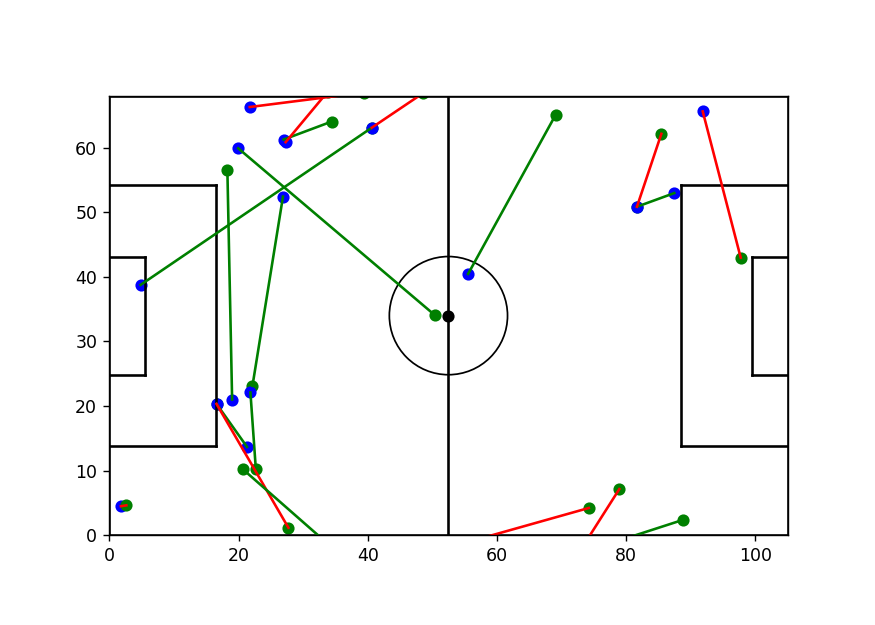

In [7]:
# A visual representation of Passes in the given dataset
#  -- blue: Pass source
#  -- green point: Pass destination
#  -- green line: Successful pass
#  -- red line: Failed pass
plt.close()
p = Pitch()

for i in range(10,30):
    source = (df["x"][i],df["y"][i])
    dest = (df["endx"][i], df["endy"][i])
    complete = True if df["outcome"][i] == 1 else False
    p.pass_map(source,dest,complete)


## Pass Completion Probability Prediction

#### Logistic Regression

In [8]:
df.columns

Index(['team_id', 'game_id', 'player_id', 'home_id', 'away_id', 'home_score',
       'away_score', 'half', 'minute', 'second', 'outcome', 'x', 'y', 'endx',
       'endy', 'hd_pass', 'cross', 'corner', 'throw', 'gk', 'gk_throw',
       'fk_taken', 'chipped'],
      dtype='object')

In [9]:
# Split the data into training and testing
df = df.dropna()
X = df.drop(['outcome','team_id', 'game_id', 'player_id', 'home_id', 'away_id', 'home_score', 'away_score', 'half', 'minute', 'second'], axis=1) # input features
X['x'] = X['x'].clip(0)
X['endx'] = X['endx'].clip(0)
y = df['outcome'] # output labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 1445)


In [10]:
X_train

,x,y,endx,endy,hd_pass,cross,corner,throw,gk,gk_throw,fk_taken,chipped
151599,57.750,34.068,56.910,46.444,0,0,0,0,0,0,0,0
141847,28.455,61.268,34.440,64.940,0,0,0,0,0,0,0,0
13365,67.095,13.056,56.280,9.724,0,0,0,0,0,0,0,0
123834,7.350,22.848,15.225,11.152,0,0,0,0,0,0,0,0
283980,45.570,36.312,50.820,59.500,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15754,49.980,34.476,33.495,30.328,0,0,0,0,0,0,0,0
336309,42.630,11.288,48.300,30.736,0,0,0,0,0,0,0,0
275291,67.830,13.532,69.825,3.060,0,0,0,0,0,0,0,0
321752,66.675,-0.544,79.275,4.080,0,0,0,1,0,0,0,0


In [11]:
# Fit Logistic regression model

logreg = LogisticRegression(max_iter=1000, solver='liblinear', verbose=1, n_jobs=1, random_state=42)

logreg.fit(X_train, y_train)


[LibLinear]

LogisticRegression(max_iter=1000, n_jobs=1, random_state=42, solver='liblinear',
                   verbose=1)

In [12]:
# Predict Probabilities on the testset
y_prob = logreg.predict_proba(X_test)[:, 1]

In [13]:
print(f"The average accuracy of the prediction on the test set is {logreg.score(X_test,y_test)}")

The average accuracy of the prediction on the test set is 0.8396393383223937


In [14]:


class PitchInteractive(Pitch):
    
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.source_point = None
        self.dest_point = None
        self.hd_pass = False
        self.cross = False
        self.corner = False
        self.throw = False
        self.gk = False
        self.gk_throw = False
        self.fk_taken = False
        self.chipped = False
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)
        
    def on_click(self, event):
        if event.button == 1:  # left mouse button
            self.source_point = (event.xdata, event.ydata)
            self.ax.scatter(self.source_point[0], self.source_point[1], color="blue")
        elif event.button == 2:  # middle mouse button
            pass  # do nothing
        elif event.button == 3:  # right mouse button
            self.dest_point = (event.xdata, event.ydata)
            self.ax.scatter(self.dest_point[0], self.dest_point[1], color="green")
            self.predict_outcome()

    def predict_outcome(self):
        if self.source_point is None or self.dest_point is None:
            print("Please select both source and destination points.")
            return
        
        # Add line between source and destination points
        

        X = [self.source_point[0], self.source_point[1], self.dest_point[0], self.dest_point[1],
             self.hd_pass, self.cross, self.corner, self.throw, self.gk, self.gk_throw, self.fk_taken, self.chipped]
        prob = self.model.predict_proba([X])[0][1]
        cl = "green" if prob>0.5 else "red"
        self.ax.plot([self.source_point[0], self.dest_point[0]], [self.source_point[1], self.dest_point[1]], color=cl)
        print("Probability of successful outcome: {:.2f}%".format(prob * 100))
        
    def set_hd_pass(self, value):
        self.hd_pass = value
        
    def set_cross(self, value):
        self.cross = value
        
    def set_corner(self, value):
        self.corner = value
        
    def set_throw(self, value):
        self.throw = value
        
    def set_gk(self, value):
        self.gk = value
        
    def set_gk_throw(self, value):
        self.gk_throw = value
        
    def set_fk_taken(self, value):
        self.fk_taken = value
        
    def set_chipped(self, value):
        self.chipped = value
    
    def show(self):
        plt.show()


<IPython.core.display.Javascript object>


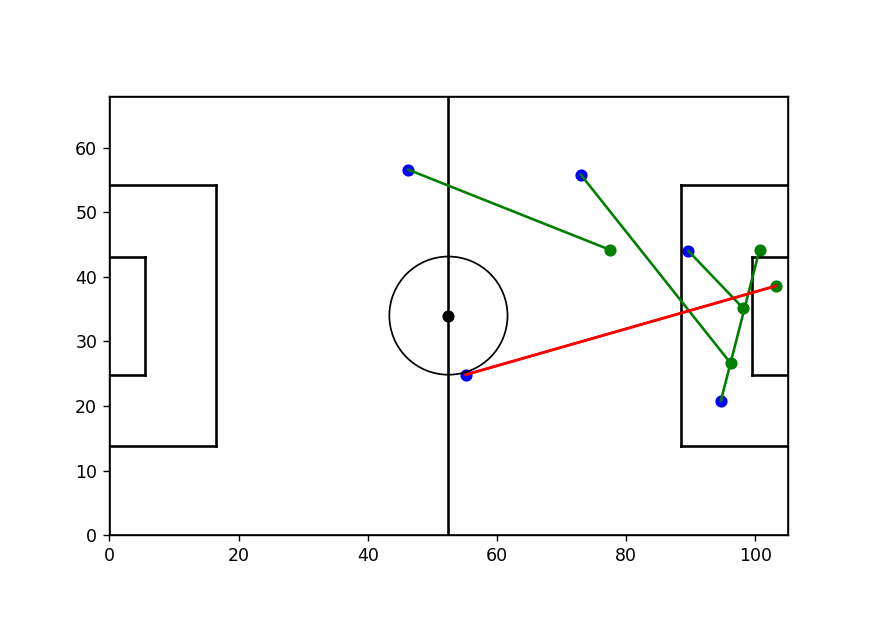

In [15]:
# Left click to add a pass source
# Right click to add a pass destination
# If the produced pass line is green, the pass is more likely to be successful
# If it is red, the pass is likely to fail

# !!!!! Please ensure that you add a pass source before adding a pass destination
# Feel free to toggle the input to observe the changes
plt.close()
pi = PitchInteractive(logreg)
pi.set_hd_pass(False)
pi.set_cross(False)
pi.set_corner(False)
pi.set_throw(False)
pi.set_gk(False)
pi.set_gk_throw(False)
pi.set_fk_taken(False)
pi.set_chipped(False)


In [16]:
# Predicts the pass success probability for the last entered pass
pi.predict_outcome()

Probability of successful outcome: 19.81%


C:\Users\rgpma\anaconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


<IPython.core.display.Javascript object>


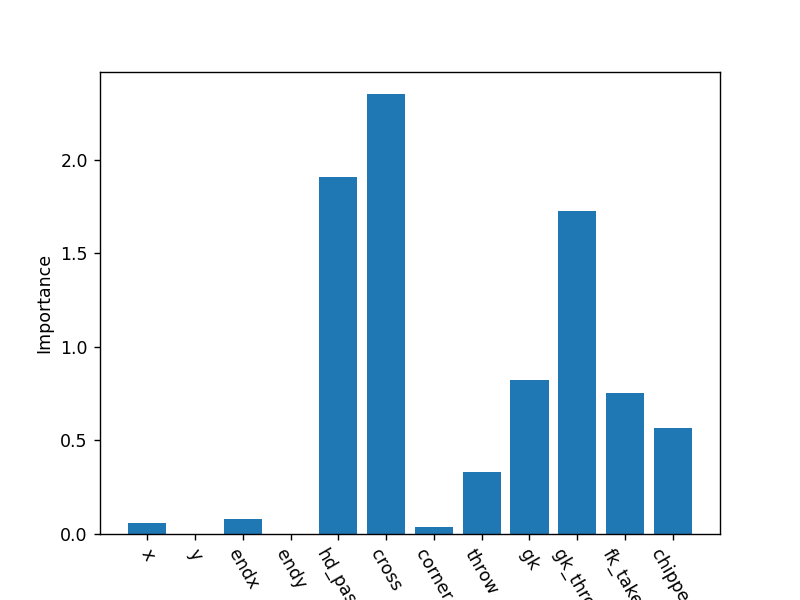

In [17]:
importances = abs(logreg.coef_[0])
plt.close()
# Plot the feature importances
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), X.columns, rotation=300)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

# Multi Layer perceptron (Basic)

In [18]:
class Passloader(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()
        self.y = torch.from_numpy(y.values).float()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        features = self.X[idx]
        label = self.y[idx]
        return features, label
        

In [19]:
dataset = Passloader(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

test_set = Passloader(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [20]:
class MLP(nn.Module):
    
    def __init__(self, input_dim):
        super(MLP,self).__init__()
        
        self.l1 = nn.Linear(input_dim, 100)
        self.l2 = nn.Linear(100, 100)
        self.l3 = nn.Linear(100,2)
        self.relu = nn.ReLU()
        self.sm = nn.Softmax(dim = 1)
    
    def forward(self,x):
        
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        #x = self.sm(x)
        return x
        

In [21]:
num_epochs = 10
input_size = len(X_train.columns)
model = MLP(input_size)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
torch.manual_seed(43)
for i in tqdm(range(num_epochs)):
    total_loss = 0
    for b, (features, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        y_pred = model(features)
        labels = labels.long()
        loss = criterion(y_pred, labels)
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss.append(total_loss/b)
    with torch.no_grad():
        total_test_loss = 0
        for tb,(tf,tl) in enumerate(test_loader):
            test_pred = model(tf)
            tl = tl.long()
            t_loss = criterion(test_pred,tl)
            total_test_loss+= t_loss.item()
    
    test_loss.append(total_test_loss/tb)
    
    print(f"The training loss at the {i}th epoch is {total_loss/b} and the test loss is {total_test_loss/tb}")


The training loss at the 0th epoch is 0.3701648049548361 and the test loss is 0.33617408134967064
The training loss at the 1th epoch is 0.3333668850701266 and the test loss is 0.3251051604083135
The training loss at the 2th epoch is 0.31724466451416317 and the test loss is 0.306494910598971
The training loss at the 3th epoch is 0.3125194072404363 and the test loss is 0.30897259922244524
The training loss at the 4th epoch is 0.31037722087326486 and the test loss is 0.31109361367816907
The training loss at the 5th epoch is 0.30811686073924205 and the test loss is 0.30604478667667145
The training loss at the 6th epoch is 0.30676006663002464 and the test loss is 0.3067393050488354
The training loss at the 7th epoch is 0.30576645276350545 and the test loss is 0.30560588342180006
The training loss at the 8th epoch is 0.30501436157838296 and the test loss is 0.3051422259618298
The training loss at the 9th epoch is 0.30476837690477654 and the test loss is 0.30326985113861094



<IPython.core.display.Javascript object>


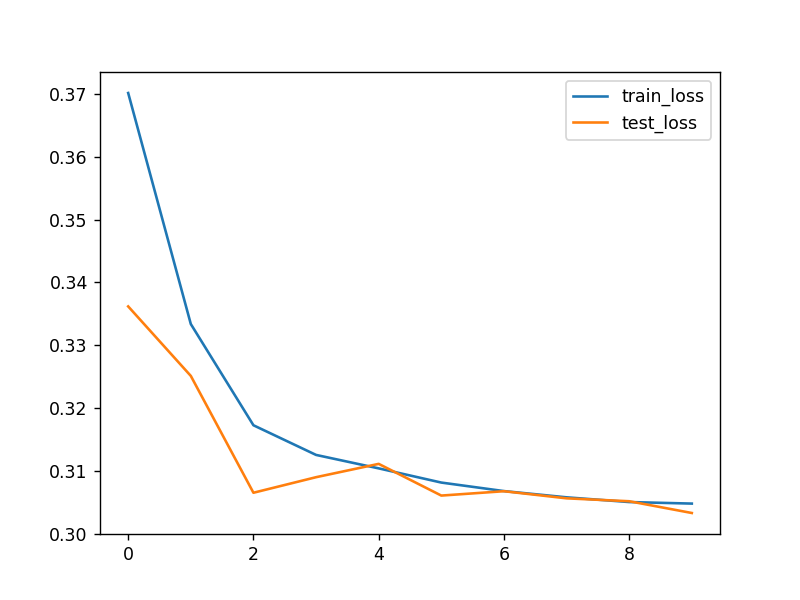

In [23]:
plt.close()
plt.plot(train_loss, label ="train_loss")
plt.plot(test_loss,label ="test_loss")
plt.legend()

In [24]:


class PitchInteractiveMLP(Pitch):
    
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.source_point = None
        self.dest_point = None
        self.hd_pass = False
        self.cross = False
        self.corner = False
        self.throw = False
        self.gk = False
        self.gk_throw = False
        self.fk_taken = False
        self.chipped = False
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)
        
    def on_click(self, event):
        if event.button == 1:  # left mouse button
            self.source_point = (event.xdata, event.ydata)
            self.ax.scatter(self.source_point[0], self.source_point[1], color="blue")
        elif event.button == 2:  # middle mouse button
            pass  # do nothing
        elif event.button == 3:  # right mouse button
            self.dest_point = (event.xdata, event.ydata)
            self.ax.scatter(self.dest_point[0], self.dest_point[1], color="green")
            self.predict_outcome()
    
    def predict(self, ip):
        self.sm = nn.Softmax(dim=1)
        return self.sm(self.model(ip.unsqueeze(0)))

    def predict_outcome(self):
        if self.source_point is None or self.dest_point is None:
            print("Please select both source and destination points.")
            return
        
        # Add line between source and destination points
        

        X = [self.source_point[0], self.source_point[1], self.dest_point[0], self.dest_point[1],
             self.hd_pass, self.cross, self.corner, self.throw, self.gk, self.gk_throw, self.fk_taken, self.chipped]
        X = torch.Tensor(X)
        prob = self.predict(X)[0].data[1].item()
        cl = "green" if prob>0.5 else "red"
        self.ax.plot([self.source_point[0], self.dest_point[0]], [self.source_point[1], self.dest_point[1]], color=cl)
        print("Probability of successful outcome: {:.2f}%".format(prob * 100))
        
    def set_hd_pass(self, value):
        self.hd_pass = value
        
    def set_cross(self, value):
        self.cross = value
        
    def set_corner(self, value):
        self.corner = value
        
    def set_throw(self, value):
        self.throw = value
        
    def set_gk(self, value):
        self.gk = value
        
    def set_gk_throw(self, value):
        self.gk_throw = value
        
    def set_fk_taken(self, value):
        self.fk_taken = value
        
    def set_chipped(self, value):
        self.chipped = value
    
    def show(self):
        plt.show()


<IPython.core.display.Javascript object>


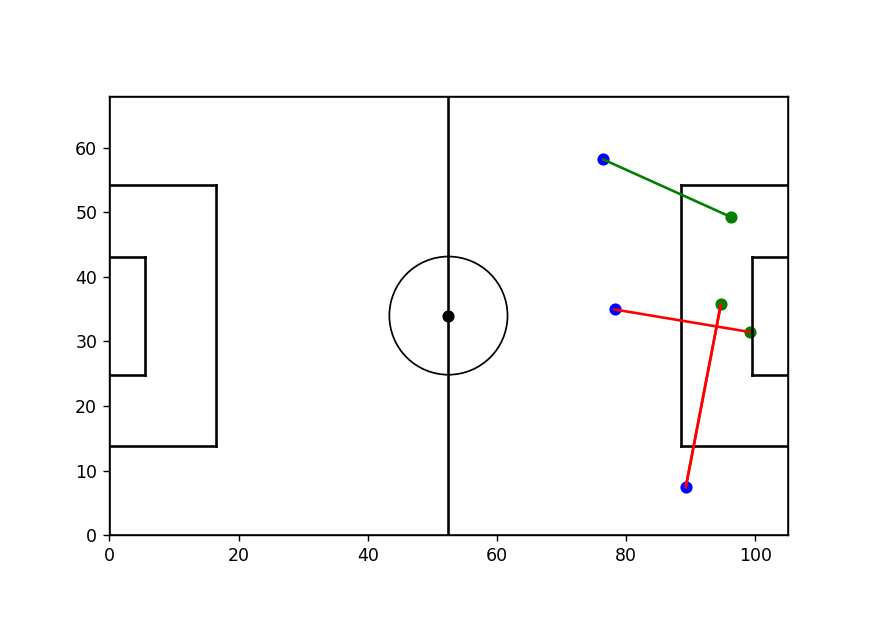

In [25]:
# Left click to add a pass source
# Right click to add a pass destination
# If the produced pass line is green, the pass is more likely to be successful
# If it is red, the pass is likely to fail

# !!!!! Please ensure that you add a pass source before adding a pass destination
# Feel free to toggle the input to observe the changes
plt.close()
pi = PitchInteractiveMLP(model)
pi.set_hd_pass(False)
pi.set_cross(False)
pi.set_corner(False)
pi.set_throw(False)
pi.set_gk(False)
pi.set_gk_throw(False)
pi.set_fk_taken(False)
pi.set_chipped(False)

In [26]:
pi.predict_outcome()

Probability of successful outcome: 44.38%


In [27]:
new_set = Passloader(X, y)
new_loader = DataLoader(new_set, batch_size=64, shuffle=False)
pass_probs = []
sm = nn.Softmax(dim=1)
for features, labels in tqdm(new_loader):
    y_pred = sm(model(features))[:,1].data#[0].data[1].data
    pass_probs.extend(y_pred.tolist())



    

In [28]:
# Add pass_probs as a dataframe column
df["pass_probs"] = pass_probs

In [29]:


class PassHeatmapPitch(Pitch):
    def pass_heatmap(self, X):
        # Extract the source and destination points and probabilities from the DataFrame
        source_points = X[['x', 'y']].values
        destination_points = X[['endx', 'endy']].values
        pass_probabilities = X['pass_probs'].values

        # Define the grid to create the heatmap
        x_grid = np.linspace(0, 105, 50)
        y_grid = np.linspace(0, 68, 50)
        x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

        # Interpolate the pass probabilities onto the grid
        heatmap = np.zeros_like(x_mesh)
        for i in range(len(source_points)):
            xi = np.argmin(np.abs(x_grid - source_points[i, 0]))
            yi = np.argmin(np.abs(y_grid - source_points[i, 1]))
            heatmap[yi, xi] += pass_probabilities[i]

        heatmap = np.flip(heatmap, axis=0)
        
        # Normalize the heatmap to the range [0, 1]
        max_value = np.max(heatmap)
        heatmap = heatmap / max_value

        # Add the heatmap to the plot
        cmap = cm.get_cmap('Reds')
        im = self.ax.imshow(heatmap, cmap=cmap, extent=[0, 105, 0, 68], alpha=0.5, origin='lower')
        
        cbar = self.fig.colorbar(im, ax=self.ax)
        cbar.set_label('Pass Probability')


<IPython.core.display.Javascript object>


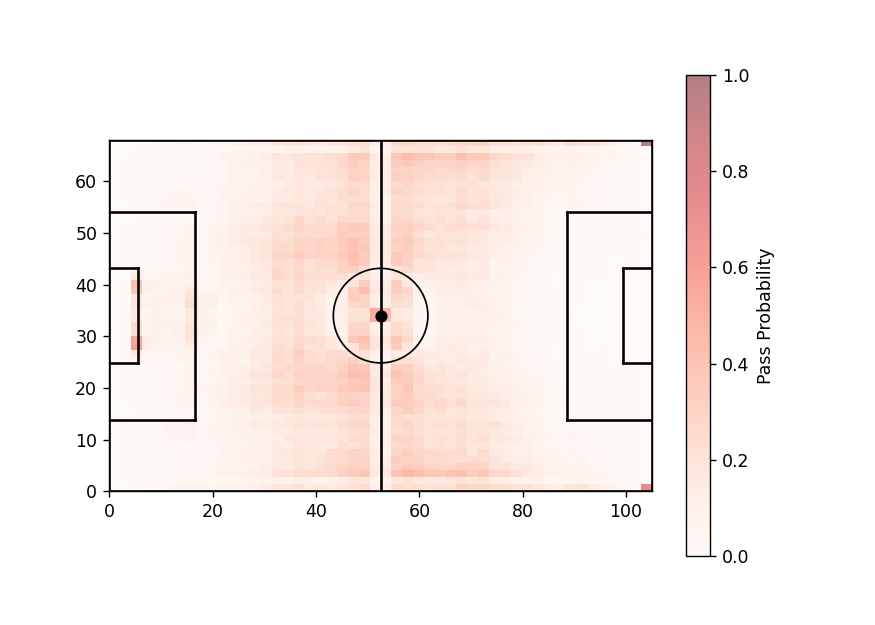

In [30]:
# This plot takes around 5 seconds to load
plt.close()
pitch = PassHeatmapPitch()
pitch.pass_heatmap(df)

# Using the previous results to Predict Player Passing Ability

In [31]:
# Get average passing probabilities for each player
# This gives us information about the regions, types of passes and difficulty of pass that each player attempts
# We want to asses a players ability to pass, while correcting for the influence of the probabilities of the passes that they attempt
player_pass_probs = df.groupby(['player_id'])['pass_probs'].mean()
player_pass_accuracy = df.groupby(['player_id'])['outcome'].mean()

In [32]:
#Evaluate the level of correlation between player_pass_probs and player_pass_accuracy
corr_coef, p_value = pearsonr(player_pass_probs, player_pass_accuracy)
print("Pearson's correlation coefficient:", corr_coef)
print("p-value:", p_value)

Pearson's correlation coefficient: 0.8536742109598069
p-value: 1.7819689795563455e-204


<IPython.core.display.Javascript object>


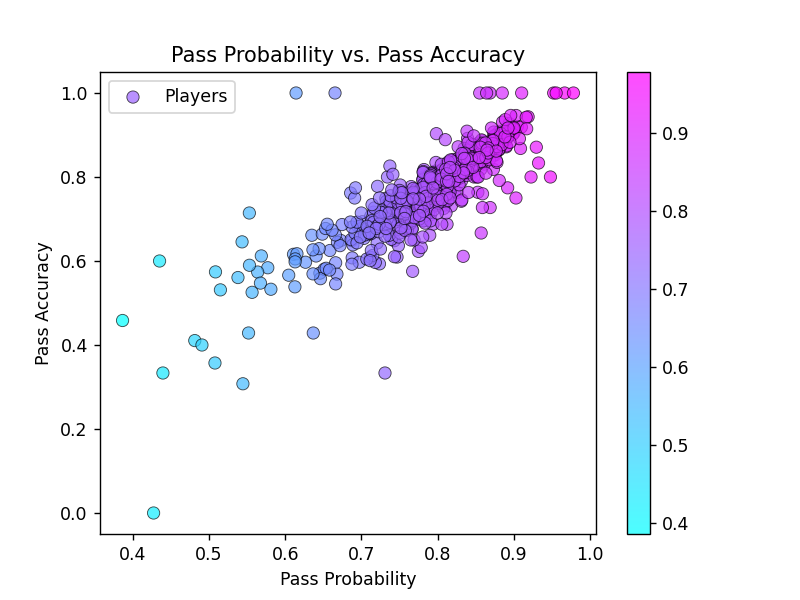

In [33]:
# plt.scatter(player_pass_accuracy, player_pass_probs)
# plt.show()
plt.close()
plt.scatter(player_pass_probs, player_pass_accuracy, c=player_pass_probs, cmap='cool', alpha=0.7, s=50, edgecolors='k', linewidths=0.5)
plt.colorbar()

plt.title('Pass Probability vs. Pass Accuracy')
plt.xlabel('Pass Probability')
plt.ylabel('Pass Accuracy')

plt.legend(['Players'], loc='upper left')

plt.show()

In [34]:
# Fit a simple OLS model that will allow us to estimate the impact that pass probabilities have on the outcome.
# Since our probabilities do not take into account a players skill level, but the pass completion rates are influenced by the pass probabilities
# Knowing the impact that passing probabilites have on the players' pass accuracy will allow us to generate an estimate of accuracy, while correcting for the influence of probability

X = player_pass_probs
y = player_pass_accuracy

X = stm.add_constant(X)

model = stm.OLS(y, X).fit()

#print(model.summary())

predicted_A = model.predict(X)

residuals = y - predicted_A

True_accuracy = y + residuals 



C:\Users\rgpma\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [35]:
# Convert it into a dataFrame and view it
Passing_ability = pd.DataFrame(True_accuracy, columns= ["Player_Accuracy"])
Passing_ability.head()

,Player_Accuracy
player_id,
0,0.703475
1,0.799212
2,0.850584
3,0.578905
4,0.724433


In [36]:
# Create a DataFrame, where players are grouped by the total number of passes they have made
# I have chosen the minutes column purely out of convenience. All this code does is count the number of times a player has made a pass in our dataset
player_minutes = df.groupby(['player_id'])['minute'].count()


In [37]:
player_minutes

player_id
0      115
1      102
2      651
3       91
4      561
      ... 
711     18
712     19
713     31
714     47
715     49
Name: minute, Length: 716, dtype: int64

In [38]:
print(f"The most passes played by an individual is {max(player_minutes)} \nThe least passes played by an individual is {min(player_minutes)} \nOn average, a player plays {round(np.mean(player_minutes),2)} passes")

The most passes played by an individual is 2500 
The least passes played by an individual is 1 
On average, a player plays 501.09 passes


count     716.000000
mean      501.093575
std       476.037600
min         1.000000
25%       121.500000
50%       342.500000
75%       791.250000
max      2500.000000
Name: minute, dtype: float64


<IPython.core.display.Javascript object>


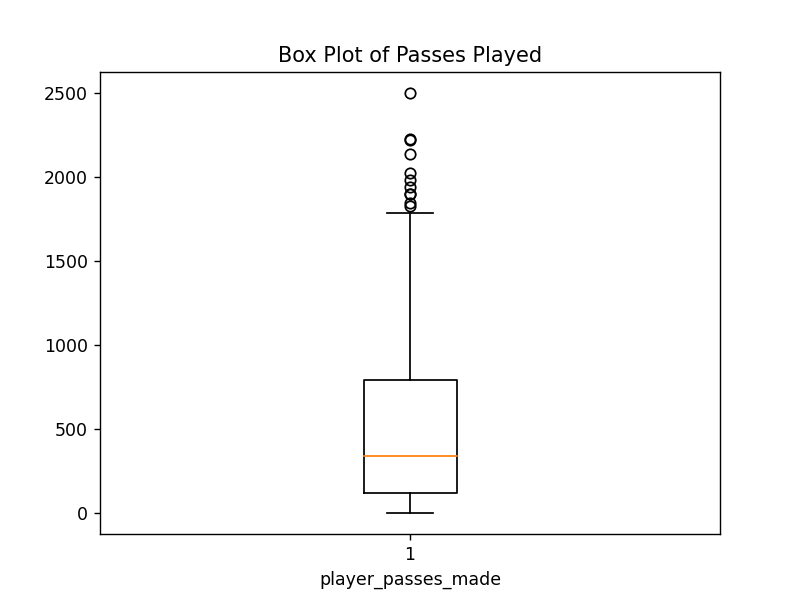

In [39]:
# Analyze the minutes data to identify a reasonable threshold
print(player_minutes.describe())
plt.close()
plt.boxplot(player_minutes)
plt.xlabel('player_passes_made')
plt.title('Box Plot of Passes Played')
plt.show()

In [40]:
# Only consider players with over 121 passing actions in a season.
Passing_ability = Passing_ability[player_minutes>=121]


<IPython.core.display.Javascript object>


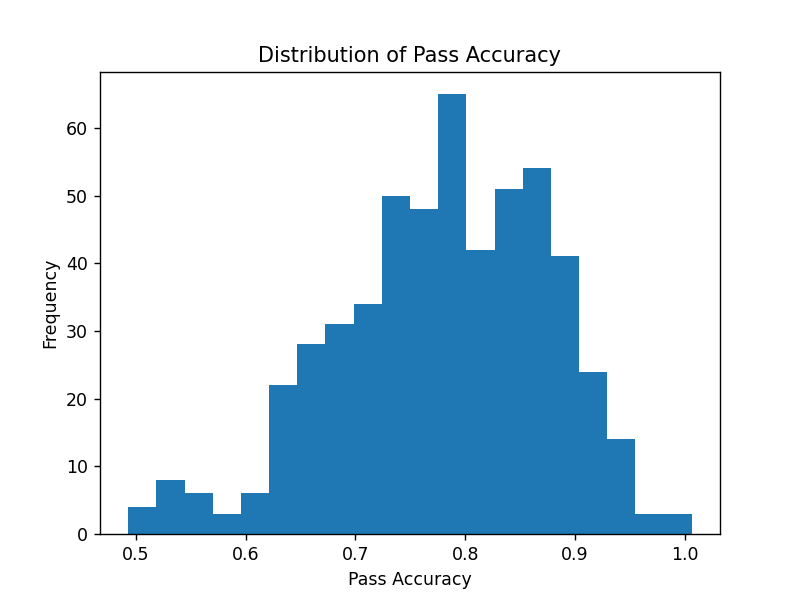

In [41]:
plt.close()
plt.hist(Passing_ability['Player_Accuracy'], bins=20)
plt.xlabel('Pass Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of Pass Accuracy')
plt.show()

<IPython.core.display.Javascript object>


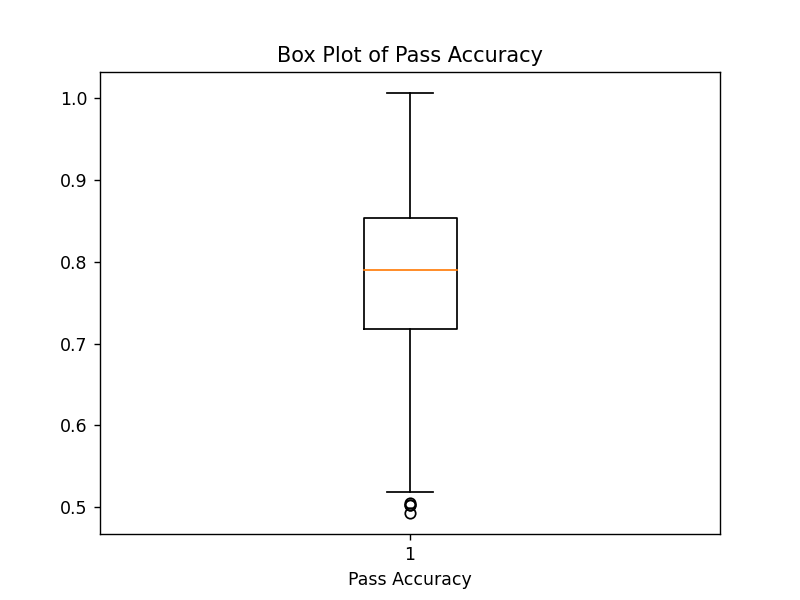

In [42]:
plt.close()
plt.boxplot(Passing_ability['Player_Accuracy'])
plt.xlabel('Pass Accuracy')
plt.title('Box Plot of Pass Accuracy')
plt.show()

In [43]:
# Add the passing action count as a coulmn into the dataframe
adj = player_minutes[player_minutes>=121]
Passing_ability["minutes"] = adj

In [44]:
Passing_ability

,Player_Accuracy,minutes
player_id,,
2,0.850584,651
4,0.724433,561
5,0.870206,1404
6,0.775553,344
7,0.870574,946
...,...,...
692,0.851209,130
695,0.773707,230
698,0.538782,137


<IPython.core.display.Javascript object>


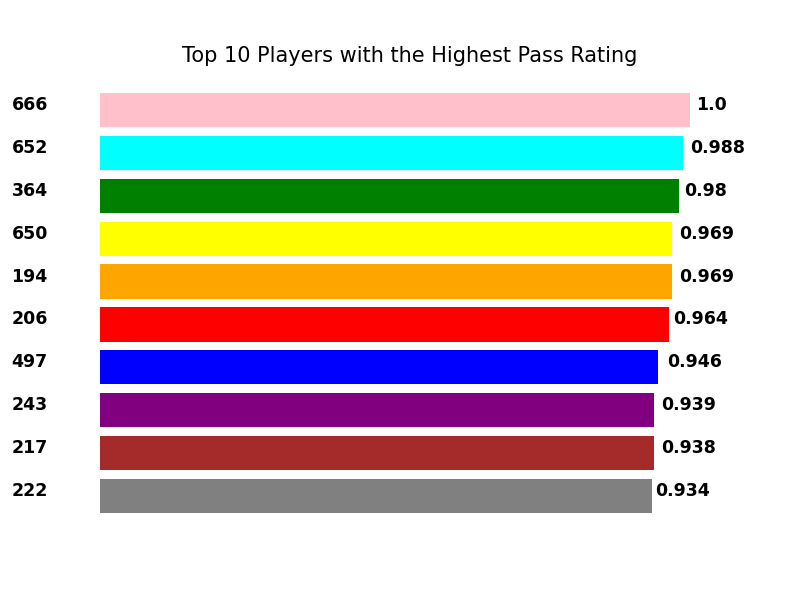

In [45]:
plt.close()
# Sort the data frame by pass accuracy in descending order and select the top 10 players
top10 = Passing_ability.sort_values('Player_Accuracy', ascending=False).head(10)

# Normalize it 

top10["Player_Accuracy"] = top10["Player_Accuracy"]/max(top10["Player_Accuracy"])

# Create a horizontal bar chart with player ID and pass accuracy
colors = ['pink', 'cyan', 'green', 'yellow', 'orange', 'red', 'blue', 'purple', 'brown', 'gray']
fig, ax = plt.subplots()
bars = ax.barh(list(range(10))[::-1], top10['Player_Accuracy'], align='center', color = colors)
ax.set_xlabel('Pass Accuracy')
ax.set_ylabel('Player ID')
ax.set_title('Top 10 Players with the Highest Pass Rating')
ax.axis('off')

# Add labels to each bar with player ID and pass accuracy
for i, v in enumerate(top10['Player_Accuracy'][::-1]):
    ax.text(round(v, 2) + 0.01, i, str(round(v, 3)), color='black', fontweight='bold')
    ax.text(-0.15, i, str(top10[::-1].index[i]), color='black', fontweight='bold')

# Create annotations for team_id, player_id, and minutes_played
annotations = [(f'Player ID: {player}\nPassing Actions completed: {minutes}', (accuracy, index))
               for index, (accuracy, player, minutes) in enumerate(
                   zip(top10.index, top10.index, top10['minutes']))]

# Add annotations to the bars with mplcursors
mplcursors.cursor(bars, hover=True).connect('add', lambda sel: sel.annotation.set_text(annotations[sel.target.index][0]))

# Show the plot
plt.show()


# Observing passing styles of players

The final stage of proceedings would be to group players on the baisis of their passing styles
I will be focussing on the following categories:

- Progressive Passers
- Final Third entrants
- Crossers
- Long ball specialists

I am anticipating considerable overlap between the groups but this part of a the project will help to assign traits to players. 

#### Each subsection of this portion is meant to be run sequentially. If there comes a need to re-run a bit of code, please start from the point at which the new pass_style_df is declared for each subsection

count    358783.000000
mean         18.093960
std          12.438478
min           0.105000
25%           9.488183
50%          14.971110
75%          23.094993
max         106.128298
Name: dists, dtype: float64


<IPython.core.display.Javascript object>


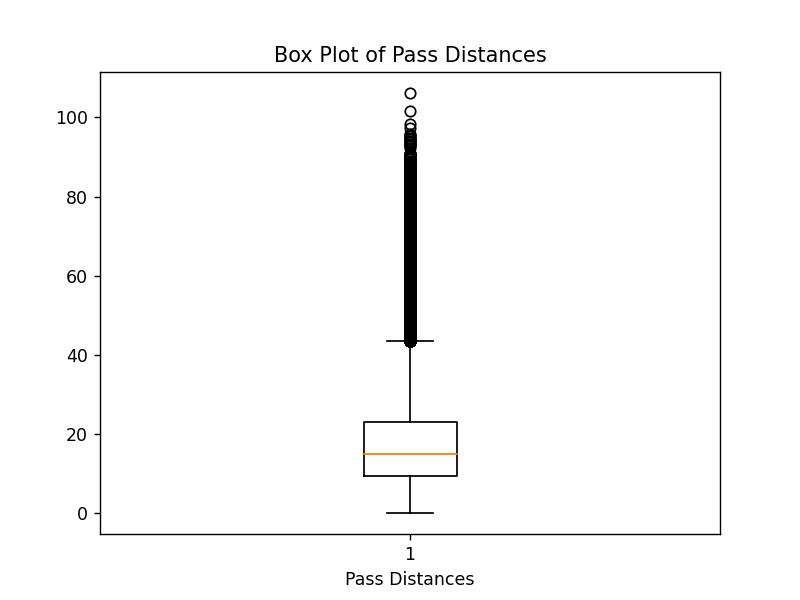

In [46]:
# Progressive passers
## I am looking at players who tend to pass forward for most of their passes but still meet certain thresholds of accuracy and distance
## In order to do this, I will start by calculating the distace of each pass in the dataset


pass_styles_df = df
dists = np.sqrt((pass_styles_df['x'] - pass_styles_df['endx'])**2 + (pass_styles_df['y'] - pass_styles_df['endy'])**2)
pass_styles_df["dists"] = dists

# We now have distance of passes for each pass in our dataset
# Let us now visualize the various metrics for pass distances in order to decide on our threshold

print(pass_styles_df["dists"].describe())
plt.close()
plt.boxplot(dists)
plt.xlabel('Pass Distances')
plt.title('Box Plot of Pass Distances')
plt.show()

In [47]:
pass_styles_df.columns


Index(['team_id', 'game_id', 'player_id', 'home_id', 'away_id', 'home_score',
       'away_score', 'half', 'minute', 'second', 'outcome', 'x', 'y', 'endx',
       'endy', 'hd_pass', 'cross', 'corner', 'throw', 'gk', 'gk_throw',
       'fk_taken', 'chipped', 'pass_probs', 'dists'],
      dtype='object')

In [48]:
# We choose 9.5 as our threshold, because it is the 25th percentile of all passes in our dataset
# Find all passes in our dataset where the distance is > 9.5 and the endx > x
# We also want to remove goalkicks and gk_throws from the equation
# This should give us a list of all progressive passes in the dataset

pass_styles_df['prog'] = ((pass_styles_df['dists']>9.5) & (pass_styles_df['endx']>pass_styles_df['x']) & (pass_styles_df['gk'] == 0) & (pass_styles_df['gk_throw'] == 0) & (pass_styles_df['outcome'] == 1)).astype(int)

count    537.000000
mean      27.077037
std       10.954010
min        8.513414
25%       18.737650
50%       24.541601
75%       34.584034
max       68.077228
dtype: float64


<IPython.core.display.Javascript object>


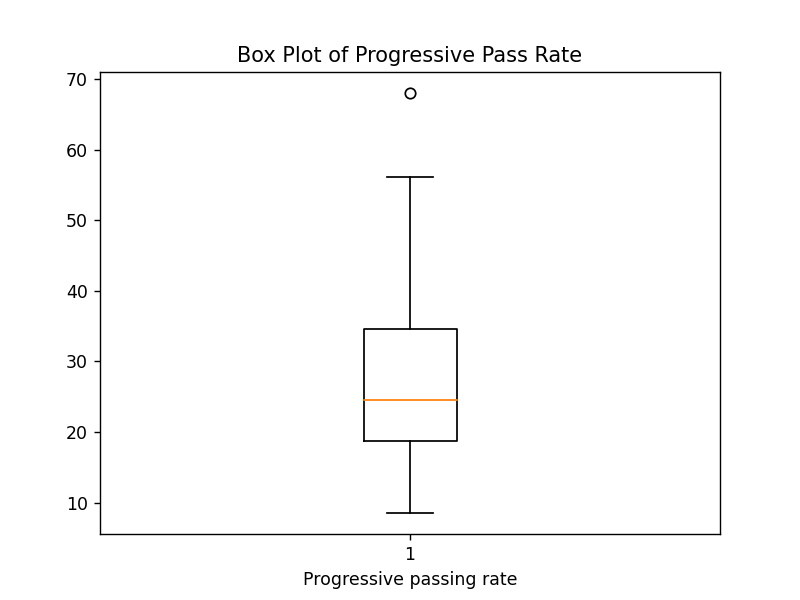

In [49]:
# The next step is to find the players who tend to pass progressively
# Group the table by players and find their progressive passing rate

player_pass_prog = pass_styles_df.groupby(['player_id'])['prog'].sum()

# Once again, we want to only consider players who have more than 121 passing actions in the dataset
player_minutes = pass_styles_df.groupby(['player_id'])['minute'].count()
player_pass_prob = pass_styles_df.groupby(['player_id'])['pass_probs'].mean()
player_pass_prog = player_pass_prog[player_minutes>121]
adj_total = player_minutes[player_minutes>121]
player_pass_prob = player_pass_prob[player_minutes>121]
player_pass_prog = (player_pass_prog/adj_total) * player_pass_prob* 100


print(player_pass_prog.describe())
plt.close()
plt.boxplot(player_pass_prog)
plt.xlabel('Progressive passing rate')
plt.title('Box Plot of Progressive Pass Rate')
plt.show()

In [50]:
# Finally, in order to carry identify Progressive passers, look for players with an average of over 34 successful progressive passes per 100.
# This puts them in the 75th percentile of progressive passers

Progressive_passers = player_pass_prog[player_pass_prog>=34]
Progressive_passers = pd.DataFrame(Progressive_passers, columns = ['prog'])
adj = player_minutes[(player_minutes>=121) & (player_pass_prog>=34)]
Progressive_passers["minutes"] = adj
# Progressive_passers['prog'] = Progressive_passers['prog']/Progressive_passers['minutes'] * 90

<IPython.core.display.Javascript object>


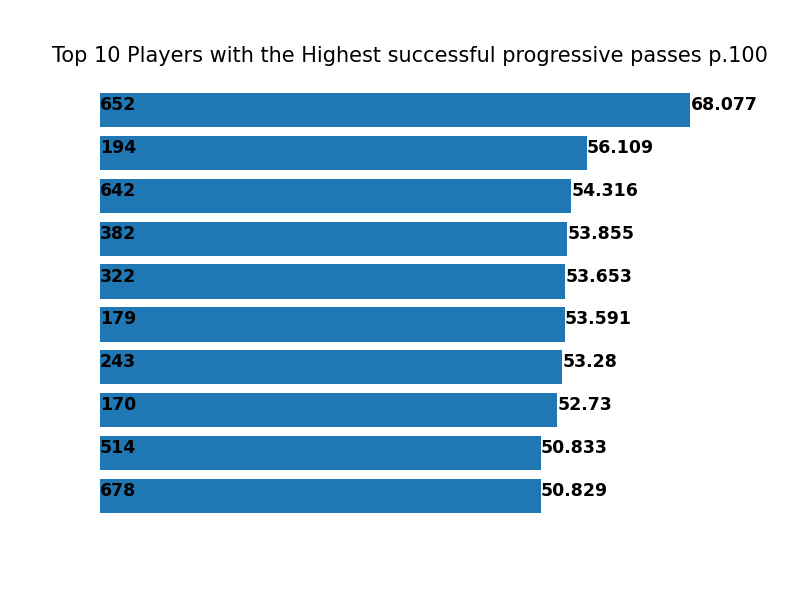

In [51]:
#As in the previous segment, I have plotted the top ten Progressive Passers

plt.close()
# Sort the data frame by pass accuracy in descending order and select the top 10 players
top10 = Progressive_passers.sort_values('prog', ascending=False).head(10)

# Create a horizontal bar chart with player ID and pass accuracy
fig, ax = plt.subplots()
bars = ax.barh(list(range(10))[::-1], top10['prog'], align='center')
ax.set_xlabel('Progressive Pass Rate')
ax.set_ylabel('Player ID')
ax.set_title('Top 10 Players with the Highest successful progressive passes p.100')
ax.axis('off')

# Add labels to each bar with player ID and pass accuracy
for i, v in enumerate(top10['prog'][::-1]):
    ax.text(round(v, 2) + 0.01, i, str(round(v, 3)), color='black', fontweight='bold')
    ax.text(-0.05, i, str(top10[::-1].index[i]), color='black', fontweight='bold')

# Create annotations for team_id, player_id, and minutes_played
annotations = [(f'Player ID: {player}\nPassing Actions completed: {minutes}', (accuracy, index))
               for index, (accuracy, player, minutes) in enumerate(
                   zip(top10.index, top10.index, top10['minutes']))]

# Add annotations to the bars with mplcursors
mplcursors.cursor(bars, hover=True).connect('add', lambda sel: sel.annotation.set_text(annotations[sel.target.index][0]))

# Show the plot
plt.show()


In [52]:
# This graph can be interpreted as follows 
### Player 652, is estimated to complete 67.456 progessive passes per 100 attempted

<IPython.core.display.Javascript object>


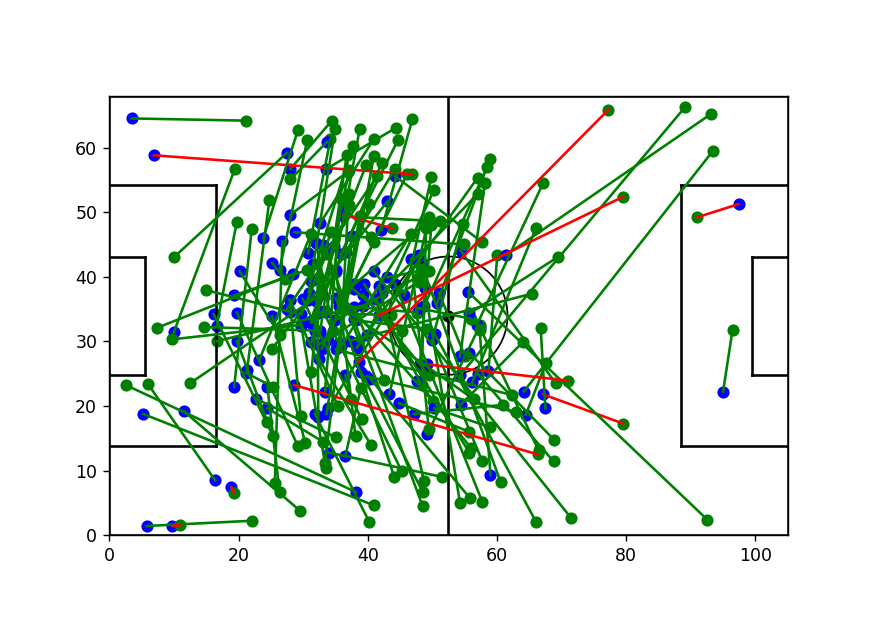

In [53]:
# Vizualize the pass map of the top progressive passer in the dataset
plt.close()
p = Pitch()
player_df = df[df['player_id'] == 652]
for index,row in player_df.iterrows():
    #print(row)
    source = (row["x"],row["y"])
    dest = (row["endx"], row["endy"])
    complete = True if row["outcome"] == 1 else False
    p.pass_map(source,dest,complete)


count    537.000000
mean      23.729437
std       13.966318
min        0.000000
25%       10.067763
50%       25.765067
75%       35.352617
max       54.383546
dtype: float64


<IPython.core.display.Javascript object>


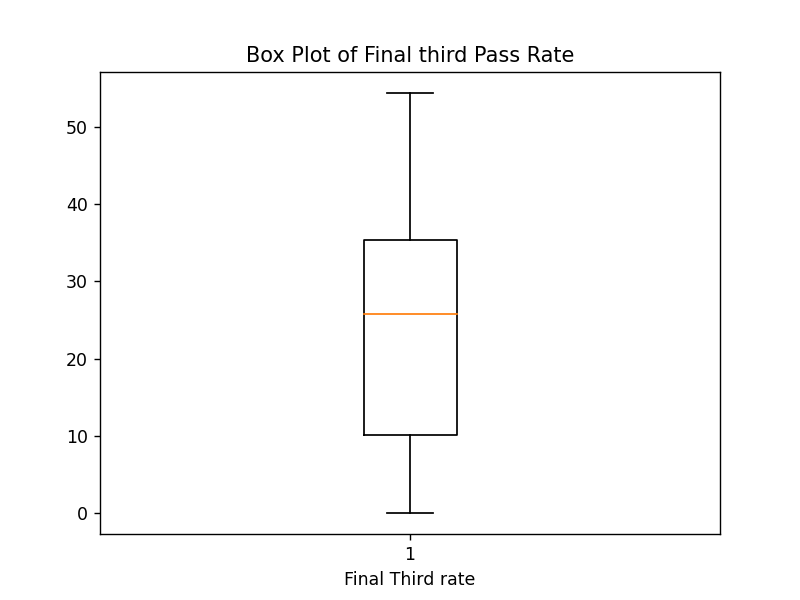

In [58]:
# The next style I will be focussing on are final third entrants
# These are players who operate in and send balls into the final third
# Similar to the Previous style, we will set certain educated thresholds. 
# The first step would be to identify the passes that have end points in the final third

pass_styles_df = df
pass_styles_df['final_third'] = ((pass_styles_df['x']>70) | (pass_styles_df['endx']>70) & (pass_styles_df['outcome'] == 1)).astype(int)
player_pass_ft = pass_styles_df.groupby(['player_id'])['final_third'].sum()

# Once again, we want to only consider players who have more than 121 passing actions in the dataset


player_minutes = pass_styles_df.groupby(['player_id'])['minute'].count()
player_pass_prob = pass_styles_df.groupby(['player_id'])['pass_probs'].mean()
player_pass_ft = player_pass_ft[player_minutes>121]
adj_total = player_minutes[player_minutes>121]
player_pass_prob = player_pass_prob[player_minutes>121]
player_pass_ft = (player_pass_ft/adj_total) * player_pass_prob* 100


print(player_pass_ft.describe())
plt.close()
plt.boxplot(player_pass_ft)
plt.xlabel('Final Third rate')
plt.title('Box Plot of Final third Pass Rate')
plt.show()

In [59]:
# Finally, in order to carry identify Final passers, look for players with an average of over 35 successful final third passes per 100 passes.
# This puts them in the 75th percentile of progressive passers

Ft_passers = player_pass_ft[player_pass_ft>=35]
Ft_passers = pd.DataFrame(Ft_passers, columns = ['final_third'])
adj = player_minutes[(player_minutes>=121) & (player_pass_ft>=35)]
Ft_passers["minutes"] = adj


In [60]:
Ft_passers

,final_third,minutes
player_id,,
11,43.388325,153
17,36.538028,401
24,40.861914,976
28,42.303398,443
34,35.748566,588
...,...,...
662,35.663945,122
679,41.702093,142
680,42.437739,228


<IPython.core.display.Javascript object>


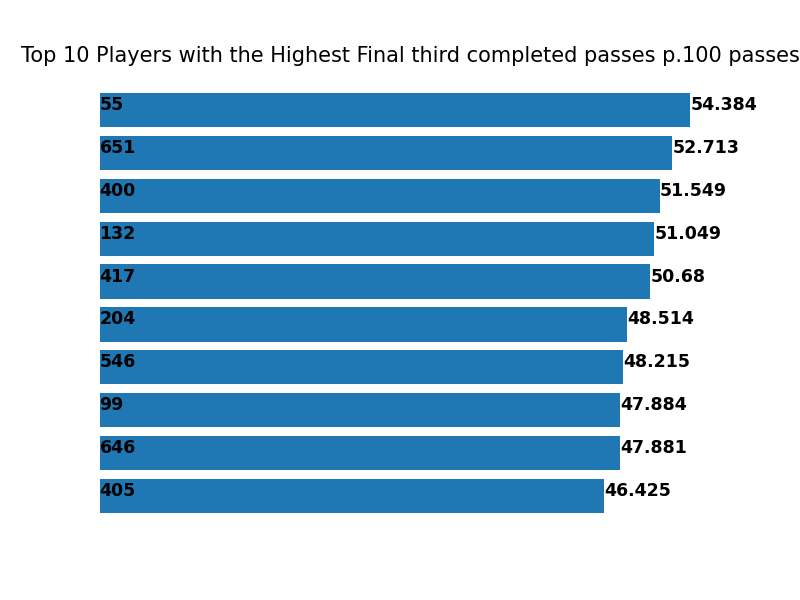

In [61]:
#As in the previous segment, I have plotted the top twenty Final third Passers

plt.close()
# Sort the data frame by pass accuracy in descending order and select the top 10 players
top10 = Ft_passers.sort_values('final_third', ascending=False).head(10)

# Create a horizontal bar chart with player ID and pass accuracy
fig, ax = plt.subplots()
bars = ax.barh(list(range(10))[::-1], top10['final_third'], align='center')
ax.set_xlabel('Progressive Pass Rate')
ax.set_ylabel('Player ID')
ax.set_title('Top 10 Players with the Highest Final third completed passes p.100 passes')
ax.axis('off')

# Add labels to each bar with player ID and pass accuracy
for i, v in enumerate(top10['final_third'][::-1]):
    ax.text(round(v, 2) + 0.01, i, str(round(v, 3)), color='black', fontweight='bold')
    ax.text(-0.05, i, str(top10[::-1].index[i]), color='black', fontweight='bold')

# Create annotations for team_id, player_id, and minutes_played
annotations = [(f'Player ID: {player}\nPassing Actions completed: {minutes}', (accuracy, index))
               for index, (accuracy, player, minutes) in enumerate(
                   zip(top10.index, top10.index, top10['minutes']))]

# Add annotations to the bars with mplcursors
mplcursors.cursor(bars, hover=True).connect('add', lambda sel: sel.annotation.set_text(annotations[sel.target.index][0]))

# Show the plot
plt.show()


<IPython.core.display.Javascript object>


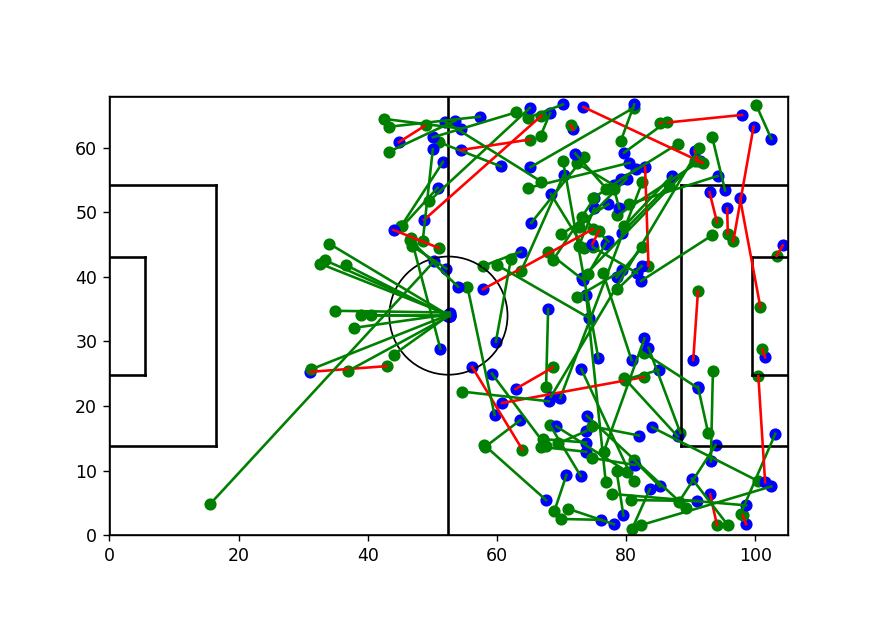

In [62]:
# Vizualize the Pass map of the best final third passer in the dataset
plt.close()
p = Pitch()
player_df = df[df['player_id'] == 55]
for index,row in player_df.iterrows():
    #print(row)
    source = (row["x"],row["y"])
    dest = (row["endx"], row["endy"])
    complete = True if row["outcome"] == 1 else False
    p.pass_map(source,dest,complete)


In [63]:
df.columns

Index(['team_id', 'game_id', 'player_id', 'home_id', 'away_id', 'home_score',
       'away_score', 'half', 'minute', 'second', 'outcome', 'x', 'y', 'endx',
       'endy', 'hd_pass', 'cross', 'corner', 'throw', 'gk', 'gk_throw',
       'fk_taken', 'chipped', 'pass_probs', 'dists', 'prog', 'final_third'],
      dtype='object')

In [69]:
# Crossers
# The next sector I am looking at are players who are prolific crossers of the football

pass_styles_df = df
pass_styles_df['successful_crosses'] = ((pass_styles_df['cross'] == 1) & (pass_styles_df['outcome'] == 1)).astype(int)
player_cross = pass_styles_df.groupby(['player_id'])['successful_crosses'].sum()




In [70]:
player_crosses = pass_styles_df.groupby(['player_id'])['cross'].sum()
player_crosses.describe()

count    716.000000
mean      20.981844
std       34.120534
min        0.000000
25%        1.000000
50%        6.000000
75%       24.000000
max      248.000000
Name: cross, dtype: float64

count    174.000000
mean      17.178790
std        5.633531
min        2.922745
25%       13.107471
50%       16.787835
75%       20.903398
max       34.159142
dtype: float64


<IPython.core.display.Javascript object>


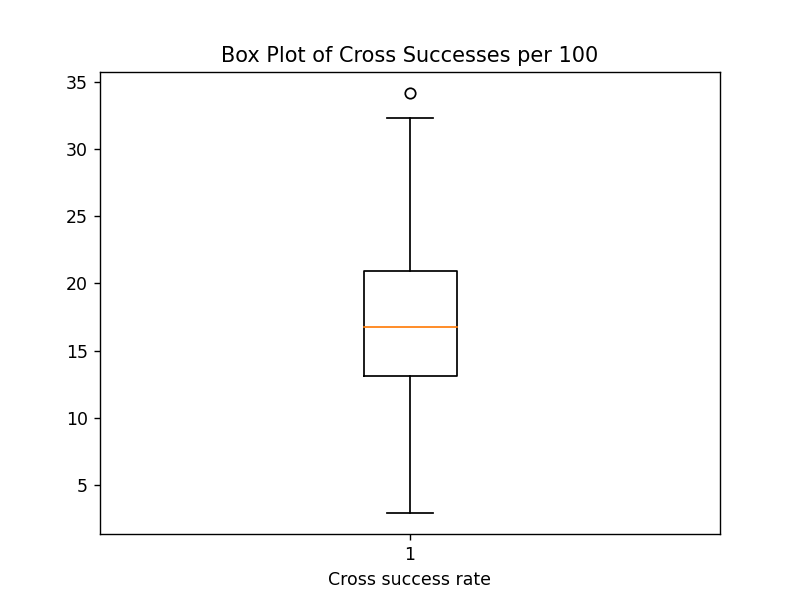

In [71]:
# Once again, we want to only consider players who have more than 25 crossing actions in the dataset

player_pass_prob = pass_styles_df.groupby(['player_id'])['pass_probs'].mean()
player_cross = player_cross[player_crosses>25]
adj_total = player_crosses[player_crosses>25]
player_pass_prob = player_pass_prob[player_crosses>25]
#print(player_cross)
player_cross = (player_cross/adj_total) * player_pass_prob* 100

print(player_cross.describe())
plt.close()
plt.boxplot(player_cross)
plt.xlabel('Cross success rate')
plt.title('Box Plot of Cross Successes per 100')
plt.show()

In [72]:
# Finally, in order to carry identify the best crossers, look for players with an average of over 20 successful final third passes per 100 passes.
# This puts them in the 75th percentile of progressive passers

best_crossers = player_cross[player_cross>=20]
best_crossers = pd.DataFrame(best_crossers, columns = ['cross_rating'])
adj = player_crosses[(player_crosses>=25) & (player_cross>=20)]
best_crossers["minutes"] = adj


<IPython.core.display.Javascript object>


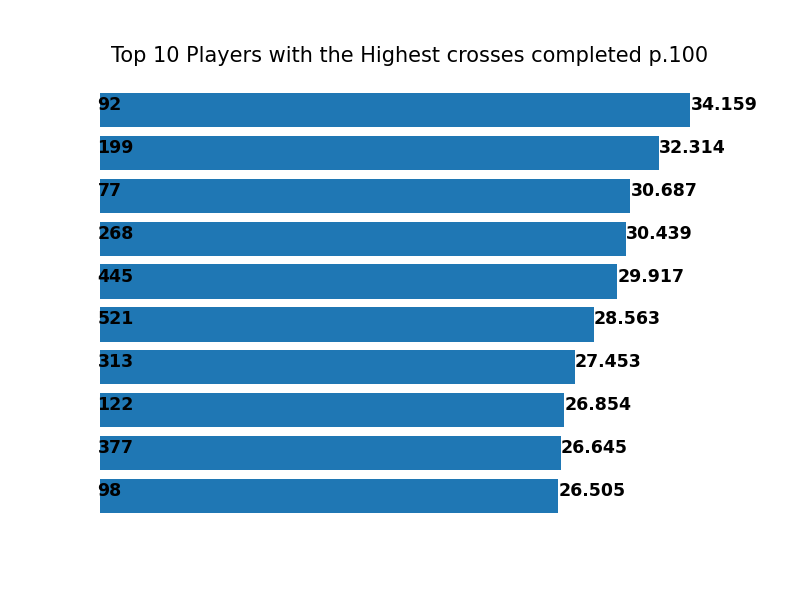

In [73]:
#As in the previous segment, I have plotted the top twenty Final third Passers

plt.close()
# Sort the data frame by pass accuracy in descending order and select the top 10 players
top10 = best_crossers.sort_values('cross_rating', ascending=False).head(10)

# Create a horizontal bar chart with player ID and pass accuracy
fig, ax = plt.subplots()
bars = ax.barh(list(range(10))[::-1], top10['cross_rating'], align='center')
ax.set_xlabel('Cross success rate per 100')
ax.set_ylabel('Player ID')
ax.set_title('Top 10 Players with the Highest crosses completed p.100')
ax.axis('off')

# Add labels to each bar with player ID and pass accuracy
for i, v in enumerate(top10['cross_rating'][::-1]):
    ax.text(round(v, 2) + 0.01, i, str(round(v, 3)), color='black', fontweight='bold')
    ax.text(-0.15, i, str(top10[::-1].index[i]), color='black', fontweight='bold')

# Create annotations for team_id, player_id, and minutes_played
annotations = [(f'Player ID: {player}\nCrossing Actions Attempted: {minutes}', (accuracy, index))
               for index, (accuracy, player, minutes) in enumerate(
                   zip(top10.index, top10.index, top10['minutes']))]

# Add annotations to the bars with mplcursors
mplcursors.cursor(bars, hover=True).connect('add', lambda sel: sel.annotation.set_text(annotations[sel.target.index][0]))

# Show the plot
plt.show()


<IPython.core.display.Javascript object>


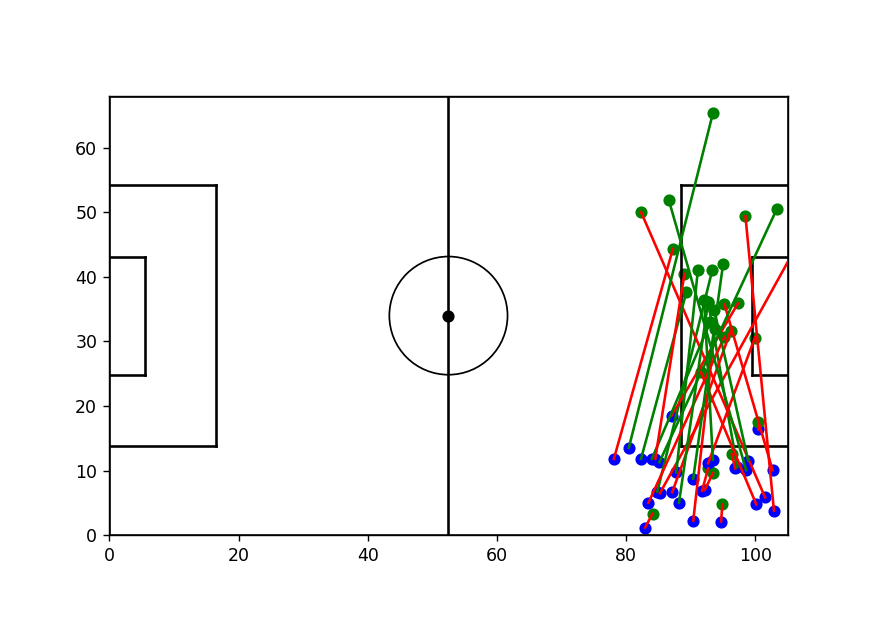

In [74]:
# Vizualize the Cross map of the top ranked crosser in the dataset
plt.close()
p = Pitch()
player_df = df[(df['player_id'] == 92) & df['cross'] ==1]
for index,row in player_df.iterrows():
    #print(row)
    source = (row["x"],row["y"])
    dest = (row["endx"], row["endy"])
    complete = True if row["outcome"] == 1 else False
    p.pass_map(source,dest,complete)


count    358783.000000
mean         18.093960
std          12.438478
min           0.105000
25%           9.488183
50%          14.971110
75%          23.094993
max         106.128298
Name: dists, dtype: float64


<IPython.core.display.Javascript object>


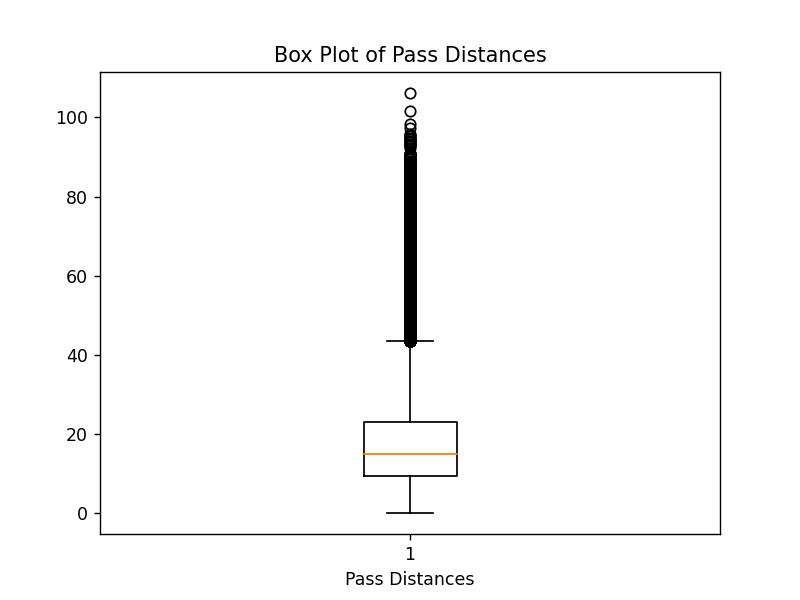

In [75]:
# Finally, we will look towards long ball specialists

pass_styles_df = df
dists = np.sqrt((pass_styles_df['x'] - pass_styles_df['endx'])**2 + (pass_styles_df['y'] - pass_styles_df['endy'])**2)
pass_styles_df["dists"] = dists

# We now have distance of passes for each pass in our dataset
# Let us now visualize the various metrics for pass distances in order to decide on our threshold

print(pass_styles_df["dists"].describe())
plt.close()
plt.boxplot(dists)
plt.xlabel('Pass Distances')
plt.title('Box Plot of Pass Distances')
plt.show()

In [76]:
# Here I choose 23 as the threshold for long balls because it lies in the 75th percentile of passs distances across a season.
pass_styles_df['long_ball'] = ((pass_styles_df['dists']>23)).astype(int)
pass_styles_df['successful_long_ball'] = ((pass_styles_df['dists']>23) & (pass_styles_df['outcome'] == 1)).astype(int)

In [77]:
attempted_long_ball = pass_styles_df.groupby(['player_id'])['long_ball'].sum()
attempted_long_ball.describe()

count    716.000000
mean     126.318436
std      142.055605
min        0.000000
25%       20.000000
50%       75.000000
75%      193.250000
max      946.000000
Name: long_ball, dtype: float64

In [78]:
player_lb = pass_styles_df.groupby(['player_id'])['successful_long_ball'].sum()

count    356.000000
mean      51.441049
std       14.223466
min       14.435353
25%       39.599279
50%       51.804674
75%       61.733135
max       84.077054
dtype: float64


<IPython.core.display.Javascript object>


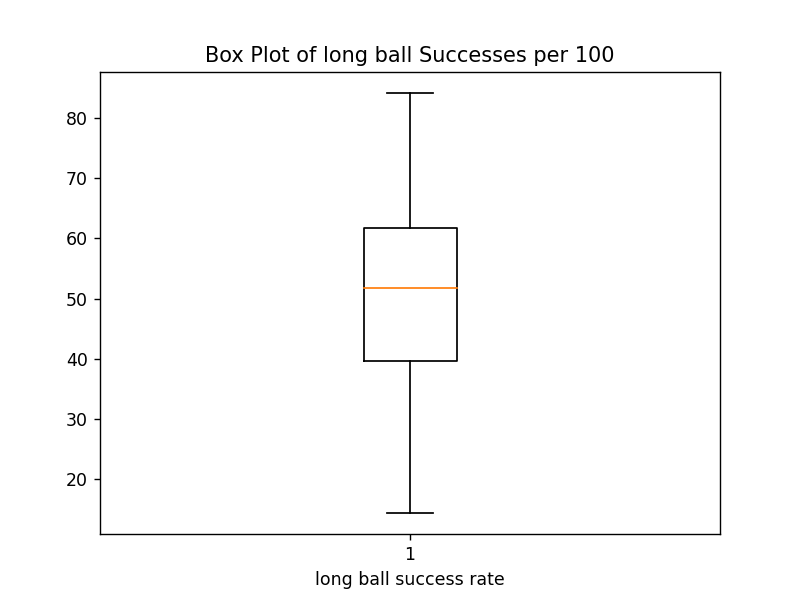

In [79]:
# Once again, we want to only consider players who have more than 75 long balls in the dataset

player_pass_prob = pass_styles_df.groupby(['player_id'])['pass_probs'].mean()
player_lb = player_lb[attempted_long_ball>75]
adj_total = attempted_long_ball[attempted_long_ball>75]
player_pass_prob = player_pass_prob[attempted_long_ball>75]
#We adjust for the players' average pass probabilities
player_lb = (player_lb/adj_total) * player_pass_prob* 100

print(player_lb.describe())
plt.close()
plt.boxplot(player_lb)
plt.xlabel('long ball success rate')
plt.title('Box Plot of long ball Successes per 100')
plt.show()

In [80]:
# Finally, in order to carry identify the long passers, look for players with an average of over 61 successful final third passes per 100 passes.
# This puts them in the 75th percentile of long passers

best_lp = player_lb[player_lb>=61]
best_lp = pd.DataFrame(best_lp, columns = ['lb_rating'])
adj = attempted_long_ball[(attempted_long_ball>=75) & (player_lb>=61)]
best_lp["minutes"] = adj

<IPython.core.display.Javascript object>


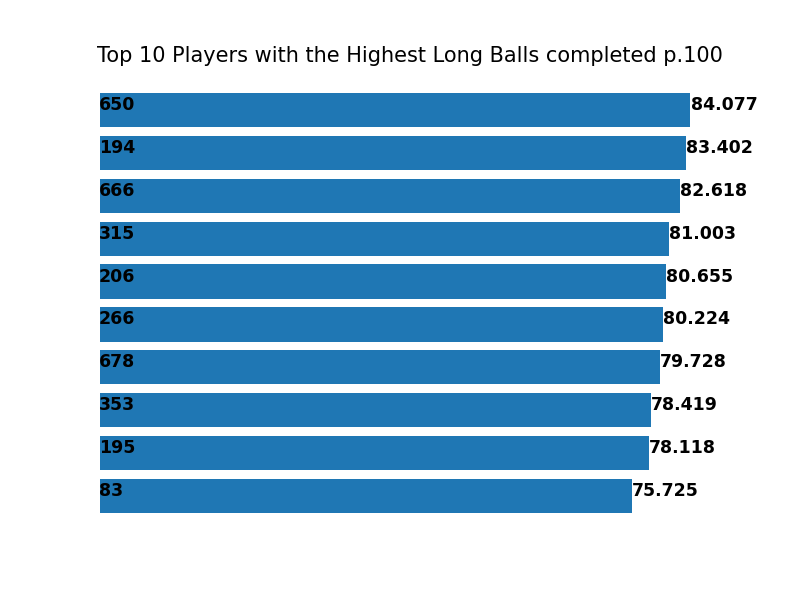

In [81]:
#As in the previous segment, I have plotted the top ten Long Passers

plt.close()
# Sort the data frame by Long ball rating in descending order and select the top 10 players
top10 = best_lp.sort_values('lb_rating', ascending=False).head(10)

# Create a horizontal bar chart with player ID and Long ball rating
fig, ax = plt.subplots()
bars = ax.barh(list(range(10))[::-1], top10['lb_rating'], align='center')
ax.set_xlabel('Long Ball success rate per 100')
ax.set_ylabel('Player ID')
ax.set_title('Top 10 Players with the Highest Long Balls completed p.100')
ax.axis('off')

# Add labels to each bar with player ID and Long ball rating
for i, v in enumerate(top10['lb_rating'][::-1]):
    ax.text(round(v, 2) + 0.01, i, str(round(v, 3)), color='black', fontweight='bold')
    ax.text(-0.15, i, str(top10[::-1].index[i]), color='black', fontweight='bold')

# Create annotations for team_id, player_id, and Long balls attempted
annotations = [(f'Player ID: {player}\nLong ball passing Actions Attempted: {minutes}', (accuracy, index))
               for index, (accuracy, player, minutes) in enumerate(
                   zip(top10.index, top10.index, top10['minutes']))]

# Add annotations to the bars with mplcursors
mplcursors.cursor(bars, hover=True).connect('add', lambda sel: sel.annotation.set_text(annotations[sel.target.index][0]))

# Show the plot
plt.show()


<IPython.core.display.Javascript object>


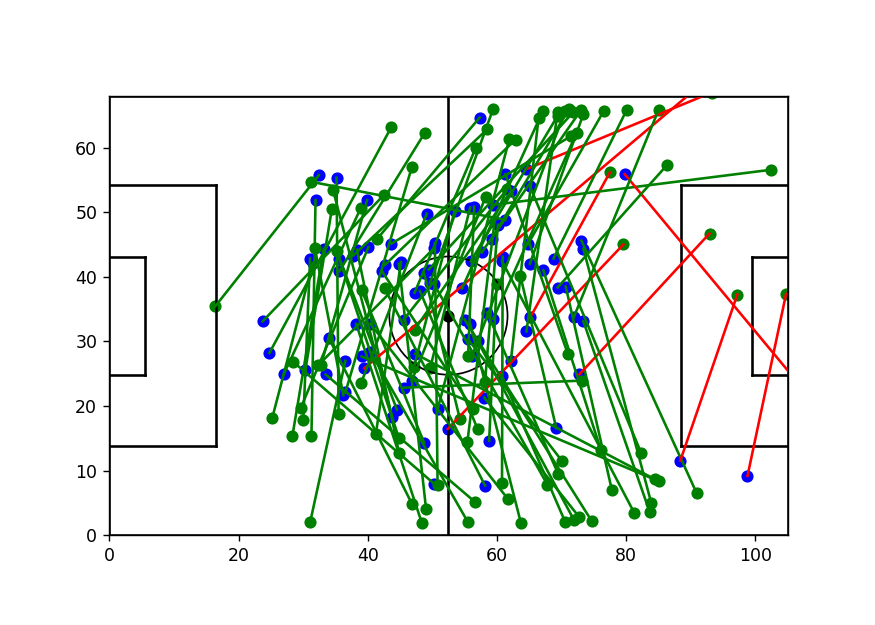

In [82]:
# Display the Pass Map of the player with the highest long passing rating in the dataset
plt.close()
p = Pitch()
player_df = pass_styles_df[(pass_styles_df['player_id'] == 650) & pass_styles_df['long_ball'] ==1]
for index,row in player_df.iterrows():
    #print(row)
    source = (row["x"],row["y"])
    dest = (row["endx"], row["endy"])
    complete = True if row["outcome"] == 1 else False
    p.pass_map(source,dest,complete)

# Please find a more comprehensive deep dive into the project in the PassingPatterns.pdf